# TP OpenMP - October 2022
## Part 1 : Pi
### Compilation

In [1]:
!nvcc -o tp_cuda_part_1_1_pi part1/tp_cuda_part_1_1_pi.cu -O3
!nvcc -o tp_cuda_part_1_3_pi part1/tp_cuda_part_1_3_pi.cu -O3
!nvcc -o tp_cuda_part_1_4_pi part1/tp_cuda_part_1_4_pi.cu -O3

### Performance evaluation

In [ ]:
import os
import subprocess
import pandas as pd
try:
    os.remove("stats_part1.csv")
except OSError:
    pass

df = pd.DataFrame(columns=['version','nthread_per_block','nstep_per_thread','num_steps','runtime'])
df.to_csv("stats_part1.csv", index=False)

num_steps = [100, 10000, 100000,1000000, 10000000, 100000000]
# num_steps = [10000, 1000000, 10000000, 100000000]
nb_threads_per_block = [1, 32, 64, 128, 256]
nb_steps_per_threads = [1, 64, 256, 1024]
repeats = range(0,10)

for nsteps in num_steps:
    for nthread_per_block in nb_threads_per_block:
        for nstep_per_thread in nb_steps_per_threads:
            for repeat in repeats:
                args = ("./tp_cuda_part_1_1_pi", "-N", str(nsteps),"-tpb", str(nthread_per_block), "-spt", str(nstep_per_thread))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()
                
                args = ("./tp_cuda_part_1_3_pi", "-N", str(nsteps),"-tpb", str(nthread_per_block), "-spt", str(nstep_per_thread))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()

                args = ("./tp_cuda_part_1_4_pi", "-N", str(nsteps),"-tpb", str(nthread_per_block), "-spt", str(nstep_per_thread))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()



### Performance analysis

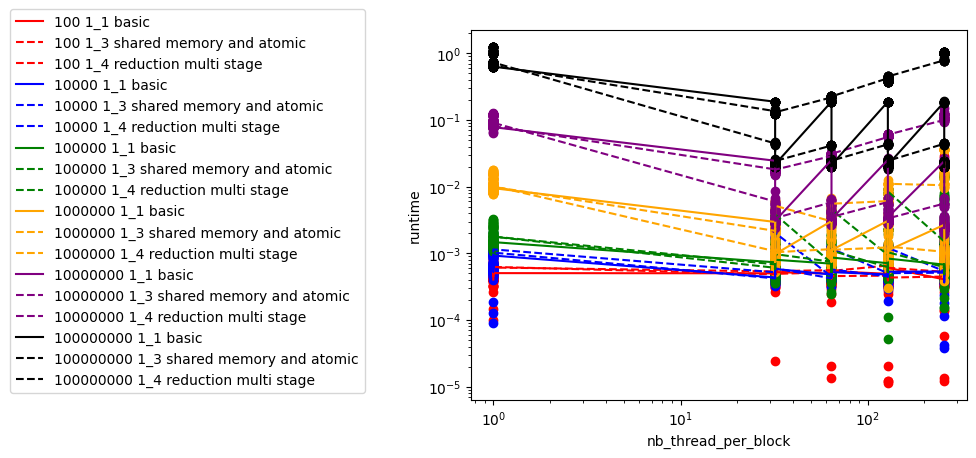

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('stats_part1.csv',header=0,names=['version','nthread_per_block','nstep_per_thread','num_steps','runtime'],dtype={
                     'version': str,
                     'nthread_per_block': int,
                     'nstep_per_thread': int,
                     'num_steps' : int,
                     'runtime' : float
                 })

color_num_steps = {100: 'red', 10000: 'blue', 100000: 'green', 1000000: 'orange', 10000000: 'purple', 100000000: 'black'}
for num_steps in df['num_steps'].drop_duplicates():
    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "1_1 basic"]
    mean_stats = df_plot.groupby(['num_steps','version','nthread_per_block','nstep_per_thread']).mean().reset_index()
    plt.plot(mean_stats['nthread_per_block'], mean_stats['runtime'],linestyle="solid",color=color_num_steps[num_steps],label=f"{num_steps} 1_1 basic")
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nthread_per_block'], df_plot['runtime'],color=color_num_steps[num_steps],label=None)

    df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == "1_3 shared memory and atomic")]    
    mean_stats = df_plot.groupby(['num_steps','version','nthread_per_block','nstep_per_thread']).mean().reset_index()    
    plt.plot(mean_stats['nthread_per_block'], mean_stats['runtime'],linestyle="dashed",color=color_num_steps[num_steps],label=f"{num_steps} 1_3 shared memory and atomic")
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nthread_per_block'], df_plot['runtime'],color=color_num_steps[num_steps],label=None)
    
    df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == "1_4 reduction multi stage")]
    mean_stats = df_plot.groupby(['num_steps','version','nthread_per_block','nstep_per_thread']).mean().reset_index()
    plt.plot(mean_stats['nthread_per_block'], mean_stats['runtime'],linestyle="dashed",color=color_num_steps[num_steps],label=f"{num_steps} 1_4 reduction multi stage")
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nthread_per_block'], df_plot['runtime'],color=color_num_steps[num_steps],label=None)

    
plt.xlabel('nb_thread_per_block')
plt.ylabel('runtime')
plt.legend(loc='lower right', bbox_to_anchor=(-0.2, 0))
plt.show()


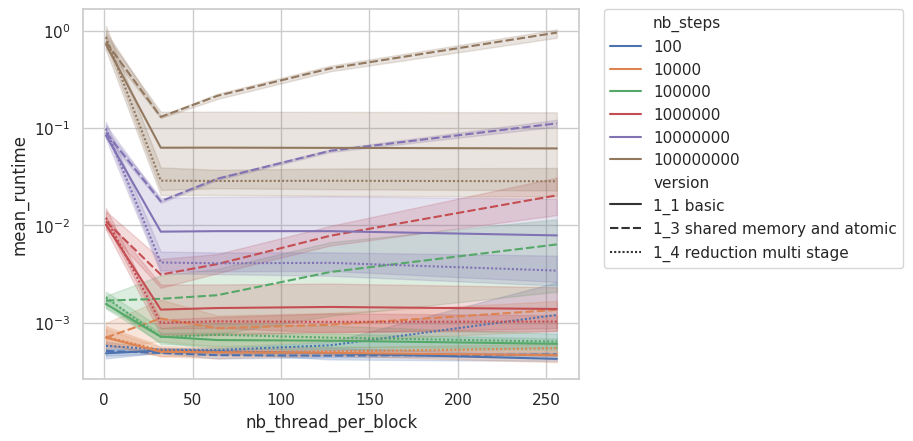

In [5]:
#Do the same as above, but with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd


df = pd.read_csv('stats_part1.csv',header=0,names=['version','nthread_per_block','nstep_per_thread','num_steps','runtime'],dtype={
                        'version': str,
                        'nthread_per_block': int,
                        'nstep_per_thread': int,
                        'num_steps' : int,
                        'runtime' : float
                    })


df_plot = df[(df['version'] == "1_1 basic")]
df_plot = df_plot.groupby(['num_steps','version','nthread_per_block','nstep_per_thread']).mean().reset_index()
df_plot['version'] = "1_1 basic"
df_plot = df_plot.rename(columns={"runtime": "mean_runtime"})
df_plot = df_plot.rename(columns={"nthread_per_block": "nb_thread_per_block"})
df_plot = df_plot.rename(columns={"nstep_per_thread": "nb_step_per_thread"})
df_plot = df_plot.rename(columns={"num_steps": "nb_steps"})
df_plot = df_plot[['version','nb_thread_per_block','nb_step_per_thread','nb_steps','mean_runtime']]
df_plot['nb_steps'] = df_plot['nb_steps'].astype(str)

df_plot2 = df[(df['version'] == "1_3 shared memory and atomic")]
df_plot2 = df_plot2.groupby(['num_steps','version','nthread_per_block','nstep_per_thread']).mean().reset_index()
df_plot2['version'] = "1_3 shared memory and atomic"
df_plot2 = df_plot2.rename(columns={"runtime": "mean_runtime"})
df_plot2 = df_plot2.rename(columns={"nthread_per_block": "nb_thread_per_block"})
df_plot2 = df_plot2.rename(columns={"nstep_per_thread": "nb_step_per_thread"})
df_plot2 = df_plot2.rename(columns={"num_steps": "nb_steps"})
df_plot2 = df_plot2[['version','nb_thread_per_block','nb_step_per_thread','nb_steps','mean_runtime']]
df_plot2['nb_steps'] = df_plot2['nb_steps'].astype(str)

df_plot3 = df[(df['version'] == "1_4 reduction multi stage")]
df_plot3 = df_plot3.groupby(['num_steps','version','nthread_per_block','nstep_per_thread']).mean().reset_index()
df_plot3['version'] = "1_4 reduction multi stage"
df_plot3 = df_plot3.rename(columns={"runtime": "mean_runtime"})
df_plot3 = df_plot3.rename(columns={"nthread_per_block": "nb_thread_per_block"})
df_plot3 = df_plot3.rename(columns={"nstep_per_thread": "nb_step_per_thread"})
df_plot3 = df_plot3.rename(columns={"num_steps": "nb_steps"})
df_plot3 = df_plot3[['version','nb_thread_per_block','nb_step_per_thread','nb_steps','mean_runtime']]
df_plot3['nb_steps'] = df_plot3['nb_steps'].astype(str)

df_plot = df_plot.append(df_plot2)
df_plot = df_plot.append(df_plot3)

sns.set_theme(style="whitegrid")
ax = sns.lineplot(x="nb_thread_per_block", y="mean_runtime", hue="nb_steps", style="version", data=df_plot)

ax.set_yscale('log')
#make the legend smaller,  more readable outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()



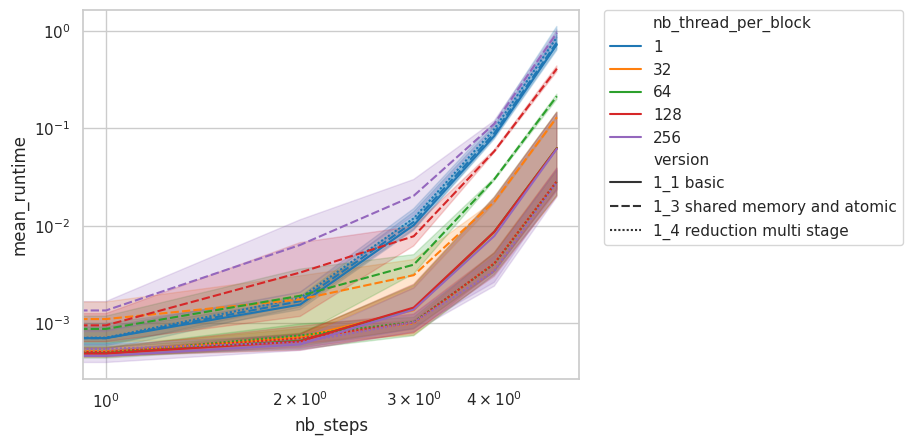

In [8]:
# Do the same as above, but with abscissa as the number of steps
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd


df = pd.read_csv('stats_part1.csv',header=0,names=['version','nthread_per_block','nstep_per_thread','num_steps','runtime'],dtype={
                        'version': str,
                        'nthread_per_block': int,
                        'nstep_per_thread': int,
                        'num_steps' : int,
                        'runtime' : float
                    })


df_plot = df[(df['version'] == "1_1 basic")]
df_plot = df_plot.groupby(['num_steps','version','nthread_per_block','nstep_per_thread']).mean().reset_index()
df_plot['version'] = "1_1 basic"
df_plot = df_plot.rename(columns={"runtime": "mean_runtime"})
df_plot = df_plot.rename(columns={"nthread_per_block": "nb_thread_per_block"})
df_plot = df_plot.rename(columns={"nstep_per_thread": "nb_step_per_thread"})
df_plot = df_plot.rename(columns={"num_steps": "nb_steps"})
df_plot = df_plot[['version','nb_thread_per_block','nb_step_per_thread','nb_steps','mean_runtime']]
df_plot['nb_steps'] = df_plot['nb_steps'].astype(str)

df_plot2 = df[(df['version'] == "1_3 shared memory and atomic")]
df_plot2 = df_plot2.groupby(['num_steps','version','nthread_per_block','nstep_per_thread']).mean().reset_index()
df_plot2['version'] = "1_3 shared memory and atomic"
df_plot2 = df_plot2.rename(columns={"runtime": "mean_runtime"})
df_plot2 = df_plot2.rename(columns={"nthread_per_block": "nb_thread_per_block"})
df_plot2 = df_plot2.rename(columns={"nstep_per_thread": "nb_step_per_thread"})
df_plot2 = df_plot2.rename(columns={"num_steps": "nb_steps"})
df_plot2 = df_plot2[['version','nb_thread_per_block','nb_step_per_thread','nb_steps','mean_runtime']]
df_plot2['nb_steps'] = df_plot2['nb_steps'].astype(str)

df_plot3 = df[(df['version'] == "1_4 reduction multi stage")]
df_plot3 = df_plot3.groupby(['num_steps','version','nthread_per_block','nstep_per_thread']).mean().reset_index()
df_plot3['version'] = "1_4 reduction multi stage"
df_plot3 = df_plot3.rename(columns={"runtime": "mean_runtime"})
df_plot3 = df_plot3.rename(columns={"nthread_per_block": "nb_thread_per_block"})
df_plot3 = df_plot3.rename(columns={"nstep_per_thread": "nb_step_per_thread"})
df_plot3 = df_plot3.rename(columns={"num_steps": "nb_steps"})
df_plot3 = df_plot3[['version','nb_thread_per_block','nb_step_per_thread','nb_steps','mean_runtime']]
df_plot3['nb_steps'] = df_plot3['nb_steps'].astype(str)

df_plot = df_plot.append(df_plot2)
df_plot = df_plot.append(df_plot3)

sns.set_theme(style="whitegrid")


ax = sns.lineplot(x="nb_steps", y="mean_runtime", hue="nb_thread_per_block", style="version", data=df_plot, palette="tab10")

ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()


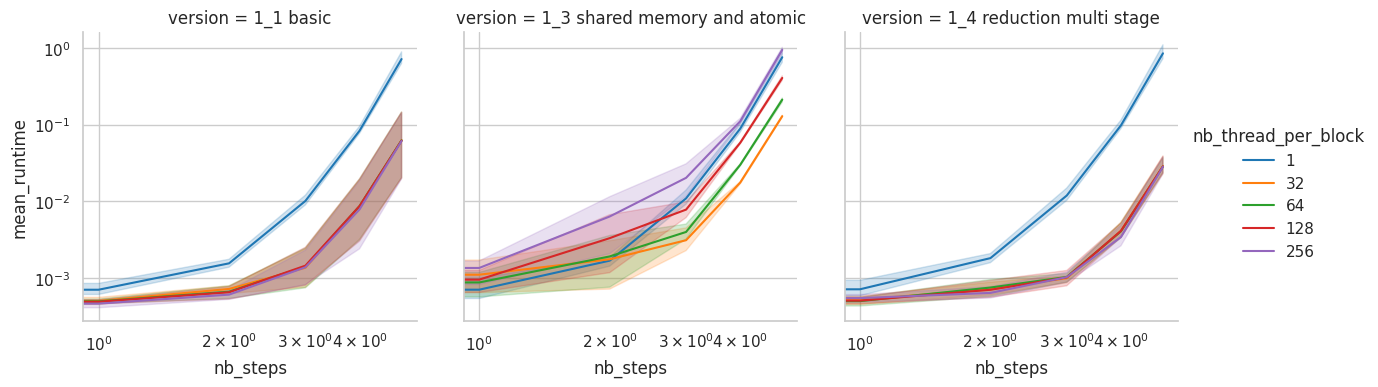

In [9]:
#plot the same as above, but each version in a different plot

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd


df = pd.read_csv('stats_part1.csv',header=0,names=['version','nthread_per_block','nstep_per_thread','num_steps','runtime'],dtype={
                        'version': str,
                        'nthread_per_block': int,
                        'nstep_per_thread': int,
                        'num_steps' : int,
                        'runtime' : float
                    })


df_plot = df[(df['version'] == "1_1 basic")]
df_plot = df_plot.groupby(['num_steps','version','nthread_per_block','nstep_per_thread']).mean().reset_index()
df_plot['version'] = "1_1 basic"
df_plot = df_plot.rename(columns={"runtime": "mean_runtime"})
df_plot = df_plot.rename(columns={"nthread_per_block": "nb_thread_per_block"})
df_plot = df_plot.rename(columns={"nstep_per_thread": "nb_step_per_thread"})
df_plot = df_plot.rename(columns={"num_steps": "nb_steps"})
df_plot = df_plot[['version','nb_thread_per_block','nb_step_per_thread','nb_steps','mean_runtime']]
df_plot['nb_steps'] = df_plot['nb_steps'].astype(str)

df_plot2 = df[(df['version'] == "1_3 shared memory and atomic")]
df_plot2 = df_plot2.groupby(['num_steps','version','nthread_per_block','nstep_per_thread']).mean().reset_index()
df_plot2['version'] = "1_3 shared memory and atomic"
df_plot2 = df_plot2.rename(columns={"runtime": "mean_runtime"})
df_plot2 = df_plot2.rename(columns={"nthread_per_block": "nb_thread_per_block"})
df_plot2 = df_plot2.rename(columns={"nstep_per_thread": "nb_step_per_thread"})
df_plot2 = df_plot2.rename(columns={"num_steps": "nb_steps"})
df_plot2 = df_plot2[['version','nb_thread_per_block','nb_step_per_thread','nb_steps','mean_runtime']]
df_plot2['nb_steps'] = df_plot2['nb_steps'].astype(str)

df_plot3 = df[(df['version'] == "1_4 reduction multi stage")]
df_plot3 = df_plot3.groupby(['num_steps','version','nthread_per_block','nstep_per_thread']).mean().reset_index()
df_plot3['version'] = "1_4 reduction multi stage"
df_plot3 = df_plot3.rename(columns={"runtime": "mean_runtime"})
df_plot3 = df_plot3.rename(columns={"nthread_per_block": "nb_thread_per_block"})
df_plot3 = df_plot3.rename(columns={"nstep_per_thread": "nb_step_per_thread"})
df_plot3 = df_plot3.rename(columns={"num_steps": "nb_steps"})
df_plot3 = df_plot3[['version','nb_thread_per_block','nb_step_per_thread','nb_steps','mean_runtime']]
df_plot3['nb_steps'] = df_plot3['nb_steps'].astype(str)


df_plot = df_plot.append(df_plot2)
df_plot = df_plot.append(df_plot3)

sns.set_theme(style="whitegrid")

g = sns.FacetGrid(df_plot, col="version", hue="nb_thread_per_block", col_wrap=3, height=4, sharex=False, sharey=True, palette="tab10")
#Change the color by the number of thread per block
g.map_dataframe(sns.lineplot, x="nb_steps", y="mean_runtime", style="version", data=df_plot)
g.set(xscale="log", yscale="log")
g.add_legend()
plt.show()



### Discussion

Bien que la version basic du code, soit séquentiel, et ne contient aucun kernel CUDA, on parvient graphiquement à distinguer des performances différentes, en fonction du nombre de threads utilisés.

La version basic du code (Code séquentiel) semble plutot performante, dans sa globalité tout comme la version 1_4, qui, à partir d'un certain nombre de steps, prend le dessus. Cela est dû au fait que cette version utilise des threads pour calculer les sommes intermédiaires, ce qui permet de réduire le temps de calcul en limitant les accès de plusieurs threads sur le même espace mémoire.



## Part 2 : Matrix-Vector operation
### Compilation

In [4]:
!nvcc -o tp_cuda_part_2_1_vector part2/tp_cuda_part_2_1_vector.cu -O3
!nvcc -o tp_cuda_part_2_2_vector part2/tp_cuda_part_2_2_vector.cu -O3
!nvcc -o tp_cuda_part_2_3_vector part2/tp_cuda_part_2_3_vector.cu -O3
!nvcc -o tp_cuda_part_2_4_vector part2/tp_cuda_part_2_4_vector.cu -O3

part2/tp_cuda_part_2_3_vector.cu(143): warning #177-D: variable "sum" was declared but never referenced



### Performance evaluation

In [5]:
import os
import subprocess
import pandas as pd
from tqdm import tqdm
try:
    os.remove("stats_part2.csv")
except OSError:
    pass

df = pd.DataFrame(columns=['version','nb_thread_per_block','N','M','repeat','runtime'])
df.to_csv("stats_part2.csv", index=False)

nb_threads_per_block = [1, 32, 64, 128, 256]
N = [2,4,8,10,12,14]
repeats = range(0,10)

for n in tqdm(N):
    for nthread_per_block in nb_threads_per_block:
        for repeat in repeats:
            args = ("./tp_cuda_part_2_1_vector","-tpb", str(nthread_per_block), "-N", str(n), "-M", str(n-1))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("./tp_cuda_part_2_2_vector","-tpb", str(nthread_per_block), "-N", str(n), "-M", str(n-1))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("./tp_cuda_part_2_3_vector","-tpb", str(nthread_per_block), "-N", str(n), "-M", str(n-1))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("./tp_cuda_part_2_4_vector","-tpb", str(nthread_per_block), "-N", str(n), "-M", str(n-1))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()



100%|██████████| 6/6 [35:34<00:00, 355.73s/it]


### Performance analysis

In [5]:
#plot runtime of the the Version and the number of thread per block vs N
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("stats_part2.csv")

df_plot = df[(df['version'] == "2_1 sequential")]
df_plot = df_plot.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
df_plot['version'] = "2_1 sequential"
df_plot = df_plot.rename(columns={"runtime": "mean_runtime"})
df_plot = df_plot[['version','nb_thread_per_block','N','mean_runtime']]
df_plot['N'] = df_plot['N'].astype(str)

df_plot2 = df[(df['version'] == "2_2 1_block_1_line")]
df_plot2 = df_plot2.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
df_plot2['version'] = "2_2 1_block_1_line"
df_plot2 = df_plot2.rename(columns={"runtime": "mean_runtime"})
df_plot2 = df_plot2[['version','nb_thread_per_block','N','mean_runtime']]
df_plot2['N'] = df_plot2['N'].astype(str)

df_plot3 = df[(df['version'] == "2_3 multiple_threads_and_atomic")]
df_plot3 = df_plot3.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
df_plot3['version'] = "2_3 multiple_threads_and_atomic"
df_plot3 = df_plot3.rename(columns={"runtime": "mean_runtime"})
df_plot3 = df_plot3[['version','nb_thread_per_block','N','mean_runtime']]
df_plot3['N'] = df_plot3['N'].astype(str)

df_plot4 = df[(df['version'] == "2_4 shared_memory")]
df_plot4 = df_plot4.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
df_plot4['version'] = "2_4 shared_memoryy"
df_plot4 = df_plot4.rename(columns={"runtime": "mean_runtime"})
df_plot4 = df_plot4[['version','nb_thread_per_block','N','mean_runtime']]
df_plot4['N'] = df_plot4['N'].astype(str)

df_plot = df_plot.append(df_plot2)
df_plot = df_plot.append(df_plot3)
df_plot = df_plot.append(df_plot4)

sns.set(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = sns.catplot(x="N", y="mean_runtime", hue="version", col="nb_thread_per_block", data=df_plot, kind="bar", height=4, aspect=1.5)

g.set_axis_labels("N", "Runtime (s)")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
plt.show()




KeyError: "['nb_steps'] not in index"

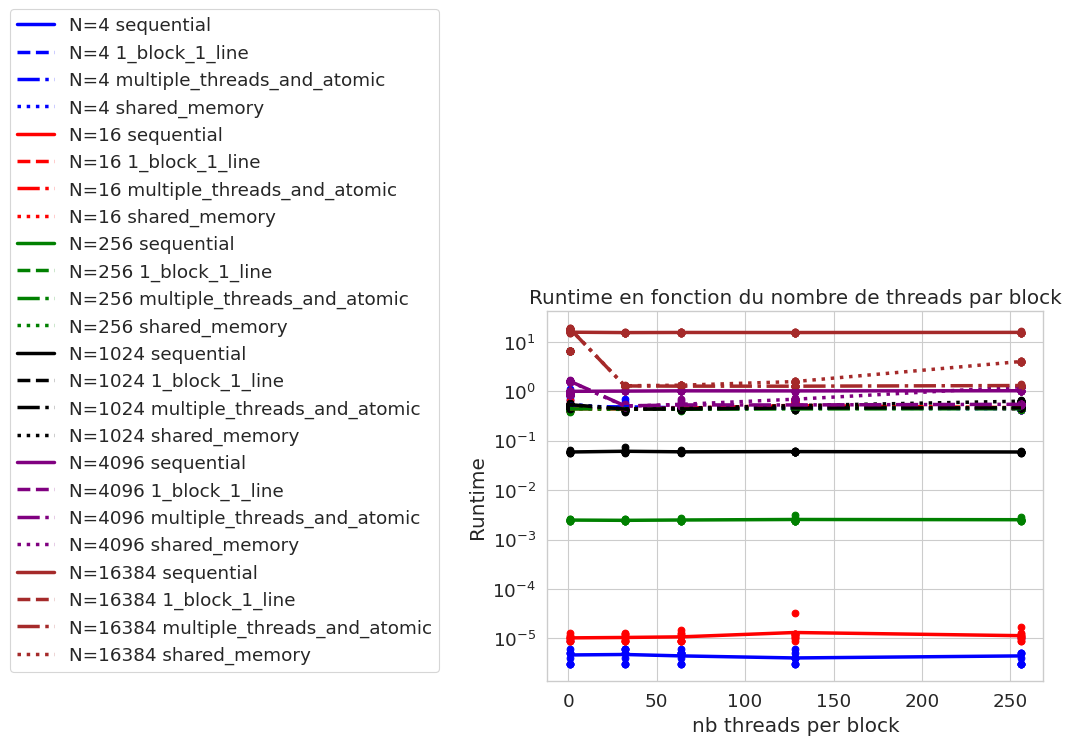

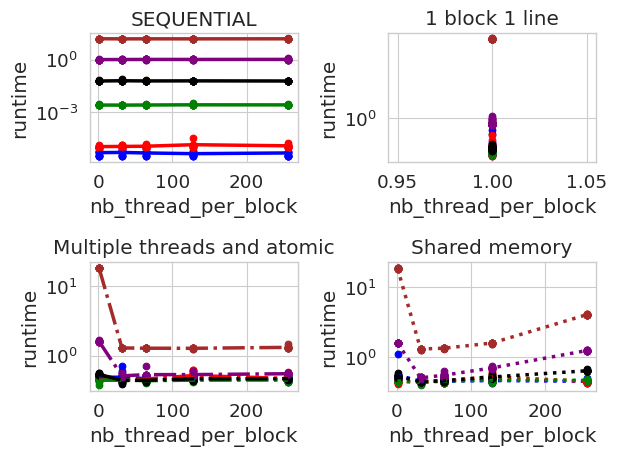

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('stats_part2.csv',header=0,names=['version','nb_thread_per_block','N','M','repeat','runtime'],dtype={
                     'version' : str,
                     'nb_thread_per_block':int,
                     'N': int,
                     'M': int,
                     'repeat' : int,
                     'runtime' : float
                 })

color_n_m = {2**2 : "blue", 2**4 : "red", 2**8 : "green", 2**10 : "black", 2**12 : "purple", 2**14 :"brown", 2**16:"pink"}

for N in df['N'].drop_duplicates():
    df_plot = df[(df['N'] == int(N))]
    df_plot = df_plot[df_plot['version'] == "2_1 sequential"]
    mean_stats = df_plot.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
    plt.plot(mean_stats['nb_thread_per_block'], mean_stats['runtime'],linestyle="solid", label=f'N={N} sequential', color=color_n_m[N])
    plt.scatter(df_plot['nb_thread_per_block'], df_plot['runtime'], label=None, color = color_n_m[N])

    df_plot = df[(df['N'] == int(N))]
    df_plot = df_plot[df_plot['version'] == "2_2 1_block_1_line"]
    mean_stats = df_plot.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
    plt.plot(mean_stats['nb_thread_per_block'], mean_stats['runtime'],linestyle="dashed", label=f'N={N} 1_block_1_line', color = color_n_m[N])
    plt.scatter(df_plot['nb_thread_per_block'], df_plot['runtime'], label=None, color = color_n_m[N])

    df_plot = df[(df['N'] == int(N))]
    df_plot = df_plot[df_plot['version'] == "2_3 multiple_threads_and_atomic"]
    mean_stats = df_plot.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
    plt.plot(mean_stats['nb_thread_per_block'], mean_stats['runtime'],linestyle="dashdot", label=f'N={N} multiple_threads_and_atomic', color = color_n_m[N])
    plt.scatter(df_plot['nb_thread_per_block'], df_plot['runtime'], label=None, color = color_n_m[N])

    df_plot = df[(df['N'] == int(N))]
    df_plot = df_plot[df_plot['version'] == "2_4 shared_memory"]
    mean_stats = df_plot.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
    plt.plot(mean_stats['nb_thread_per_block'], mean_stats['runtime'],linestyle="dotted", label=f'N={N} shared_memory', color = color_n_m[N])
    plt.scatter(df_plot['nb_thread_per_block'], df_plot['runtime'], label=None, color = color_n_m[N])

plt.yscale('log')
plt.xlabel('nb threads per block')
plt.ylabel('Runtime')
plt.title("Runtime en fonction du nombre de threads par block")
plt.legend(loc='lower right', bbox_to_anchor=(-0.2, 0))

fig = plt.figure()

#4x4 grid sublplot
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


for N in df['N'].drop_duplicates():
    df_plot = df[(df['N'] == int(N))]
    df_plot = df_plot[df_plot['version'] == "2_1 sequential"]
    mean_stats = df_plot.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
    ax1.plot(mean_stats['nb_thread_per_block'], mean_stats['runtime'],linestyle="solid", label=f'{N} sequential', color=color_n_m[N])
    ax1.set_yscale('log')
    ax1.scatter(df_plot['nb_thread_per_block'], df_plot['runtime'], label=None, color = color_n_m[N])
    ax1.set_title("SEQUENTIAL")
    ax1.set_xlabel("nb_thread_per_block")
    ax1.set_ylabel("runtime")

for N in df['N'].drop_duplicates():
    df_plot = df[(df['N'] == int(N))]
    df_plot = df_plot[df_plot['version'] == "2_2 1_block_1_line"]
    mean_stats = df_plot.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
    ax2.plot(mean_stats['nb_thread_per_block'], mean_stats['runtime'],linestyle="dashed", label=f'{N} 1_block_1_line', color = color_n_m[N])
    ax2.set_yscale('log')
    ax2.scatter(df_plot['nb_thread_per_block'], df_plot['runtime'], label=None, color = color_n_m[N])
    ax2.set_title("1 block 1 line")
    ax2.set_xlabel("nb_thread_per_block")
    ax2.set_ylabel("runtime")

for N in df['N'].drop_duplicates():
    df_plot = df[(df['N'] == int(N))]
    df_plot = df_plot[df_plot['version'] == "2_3 multiple_threads_and_atomic"]
    mean_stats = df_plot.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
    ax3.plot(mean_stats['nb_thread_per_block'], mean_stats['runtime'],linestyle="dashdot", label=f'{N} multiple_threads_and_atomic', color = color_n_m[N])
    ax3.set_yscale('log')
    ax3.scatter(df_plot['nb_thread_per_block'], df_plot['runtime'], label=None, color = color_n_m[N])
    ax3.set_title("Multiple threads and atomic")
    ax3.set_xlabel("nb_thread_per_block")
    ax3.set_ylabel("runtime")

for N in df['N'].drop_duplicates():
    df_plot = df[(df['N'] == int(N))]
    df_plot = df_plot[df_plot['version'] == "2_4 shared_memory"]
    mean_stats = df_plot.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
    ax4.plot(mean_stats['nb_thread_per_block'], mean_stats['runtime'],linestyle="dotted", label=f'{N} shared_memory', color = color_n_m[N])
    ax4.set_yscale('log')
    ax4.scatter(df_plot['nb_thread_per_block'], df_plot['runtime'], label=None, color = color_n_m[N])
    ax4.set_title("Shared memory")
    ax4.set_xlabel("nb_thread_per_block")
    ax4.set_ylabel("runtime")


plt.tight_layout()
plt.show()

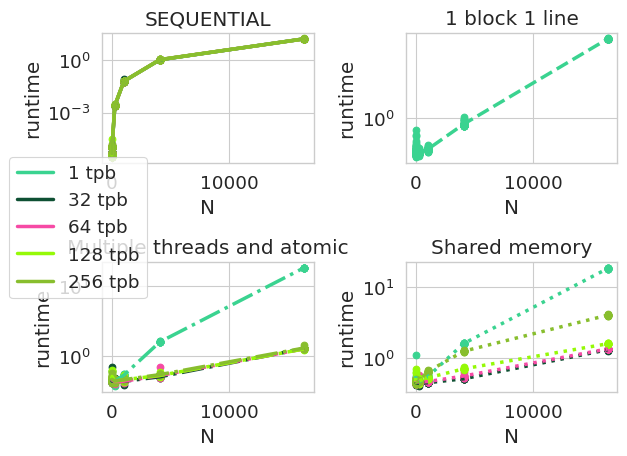

In [4]:
#Do the same as above but vs N
fig = plt.figure()

#4x4 grid sublplot
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

color_tpb = {}
for nb_thread_per_block in df['nb_thread_per_block'].drop_duplicates():
    color_tpb[nb_thread_per_block] = np.random.rand(3,)

for nb_thread_per_block in df['nb_thread_per_block'].drop_duplicates():
    df_plot = df[(df['nb_thread_per_block'] == int(nb_thread_per_block))]
    df_plot = df_plot[df_plot['version'] == "2_1 sequential"]
    mean_stats = df_plot.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
    ax1.plot(mean_stats['N'], mean_stats['runtime'],linestyle="solid", label=f'{nb_thread_per_block} sequential', color=color_tpb[nb_thread_per_block])
    ax1.set_yscale('log')
    ax1.scatter(df_plot['N'], df_plot['runtime'], label=None, color = color_tpb[nb_thread_per_block])
    ax1.set_title("SEQUENTIAL")
    ax1.set_xlabel("N")
    ax1.set_ylabel("runtime")

for nb_thread_per_block in df['nb_thread_per_block'].drop_duplicates():
    df_plot = df[(df['nb_thread_per_block'] == int(nb_thread_per_block))]
    df_plot = df_plot[df_plot['version'] == "2_2 1_block_1_line"]
    mean_stats = df_plot.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
    ax2.plot(mean_stats['N'], mean_stats['runtime'],linestyle="dashed", label=f'{nb_thread_per_block} 1_block_1_line', color = color_tpb[nb_thread_per_block])
    ax2.set_yscale('log')
    ax2.scatter(df_plot['N'], df_plot['runtime'], label=None, color = color_tpb[nb_thread_per_block])
    ax2.set_title("1 block 1 line")
    ax2.set_xlabel("N")
    ax2.set_ylabel("runtime")

for nb_thread_per_block in df['nb_thread_per_block'].drop_duplicates():
    df_plot = df[(df['nb_thread_per_block'] == int(nb_thread_per_block))]
    df_plot = df_plot[df_plot['version'] == "2_3 multiple_threads_and_atomic"]
    mean_stats = df_plot.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
    ax3.plot(mean_stats['N'], mean_stats['runtime'],linestyle="dashdot", label=f'{nb_thread_per_block} multiple_threads_and_atomic', color = color_tpb[nb_thread_per_block])
    ax3.set_yscale('log')
    ax3.scatter(df_plot['N'], df_plot['runtime'], label=None, color = color_tpb[nb_thread_per_block])
    ax3.set_title("Multiple threads and atomic")
    ax3.set_xlabel("N")
    ax3.set_ylabel("runtime")

for nb_thread_per_block in df['nb_thread_per_block'].drop_duplicates():
    df_plot = df[(df['nb_thread_per_block'] == int(nb_thread_per_block))]
    df_plot = df_plot[df_plot['version'] == "2_4 shared_memory"]
    mean_stats = df_plot.groupby(['N','version','nb_thread_per_block']).mean().reset_index()
    ax4.plot(mean_stats['N'], mean_stats['runtime'],linestyle="dotted", label=f'{nb_thread_per_block} shared_memory', color = color_tpb[nb_thread_per_block])
    ax4.set_yscale('log')
    ax4.scatter(df_plot['N'], df_plot['runtime'], label=None, color = color_tpb[nb_thread_per_block])
    ax4.set_title("Shared memory")
    ax4.set_xlabel("N")
    ax4.set_ylabel("runtime")


handles, labels = ax1.get_legend_handles_labels()
#replace labels onl the nb thread per block
labels = [label.split()[0] + " tpb" for label in labels]
#put the legend on the right outside the plot
fig.legend(handles, labels, loc='center left')




plt.tight_layout()
plt.show()


### Discussion
#### Sequential
Comme lors des précédentes analyses, nous pouvons observer que le nombre de thread n'influe pas sur les performances de l'implémentation séquentielle. En revanche, nous observons uns très forte variation du runtime lorsque le nombre de lignes de la matrice augmente, jusqu'à 16384. Cependant, cette implémentation reste très efficace voire meilleure que certaines implémentations parallélisées lorsque le nombre de lignes ne dépasse pas 1024.

#### 1 block 1 line
Dans cette implémentation, 1 bloque possède 1 thread qui s'occupe de faire le calul vectoriel sur une seule ligne. Nous observons que quelques soit la taille de la matrice cette implémentation est plus efficace que les autres. Comme dit précedemment dans certains cas l'implémentation séquentielle reste meilleure, mais n'est plus efficace pour un grand nombre de lignes dans la matrice. Tandis que celle ci continue d'avoir d'excellentes performances divisant presque par 3 le runtime de toutes les autres implémentations sur 16384 lignes. Ce phénomène est parfaitement explicable puisque nous travaillons dans cette configuration qu'avec un thread par block, le travail sera donc toujours bien réparti entre les blocs alors que dans les autres implémentations le travail ne sera pas bien réparti puisqu'ils sont optimisés pour avoir un nombre de threads plus élevés. Le temps d'éxécution est quasiment linéaire en fonction de la taille de la matrice.

#### Multiple threads and atomic operation
Comme mentionné précedemment, cette implémentation n'est pas faite pour être exécuter avec un seul thread ce qui se répercute sur les performances du programme à cause notamment des opérations atomiques. En revanche, dès que le nombre de threads augmente à 32, nous voyons une nette diminution du temps d'exécution qui est quasiment divisé par 10. Nous remarquons également que quelque soit le nombre de thread, pour des tailles de matrices équivalentes le temps d'exécution ne variera presque pas et restera toujours aux alentours de 1s. 

#### Shared memory
De même que pour l'implémentation précédente, avec un seul thread les performances ne sont pas du tout bonnes voire légèrement moins bonnes avec le passage en mémoire partagée. Néanmoins les performances seront à peu près équivalente à celle de l'implémentation précédente excéptée pour les 256 threads. Cette différence de performance peut être expliquée par l'utilisation de la mémoire partagée qui va être utilisée par de plus en plus de threads et ralentir ainsi le programme.

#### Conclusion
Finalment, nous avons pu comparé différentes implémentations et voir lesquelles étaient les plus performantes selon les usages. Lorsque nous utilisons 1 seul thread avec une matrice de petite taille nous préférerons utiliser l'implémentation séquentielle qui sera remplacée par l'implémentation parallélisée avec 1 thread par bloc gérant 1 ligne pour les matrices de plus grosse taille. Cependant, lorsque nous pourrons utiliser plus de threads et que nous aurons à faire des calculs sur de grosses matrices, l'implémentation qui semble être la plus appropriée sera celle utilisant les opératiions atomiques mais sans utiliser la mémoire partagée. En effet, cette implémentation à l'avantage d'avoir des performances linéaire quelque soit le nombre de threads ou la taille de la matrice contrairement à celle utilisant la mémoire partagée présentant des faiblesses lorsque le nombre de threads est trop important.